<a href="https://colab.research.google.com/github/annulet/CNN_NVIDIA/blob/master/hw_8_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Реализовать синтезирование лиц из LFW с помощью DCGAN.
 Библиотеки: [Python, Tensorflow]

## Переключение версии TensorFlow

In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка и подготовка датасета LFW

In [0]:
train_ds, ds_info = tfds.load(
    'lfw',
    with_info=True,
    split='train'
)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

## Визуализация датасета LFW

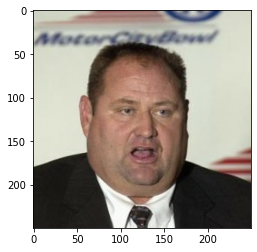

In [5]:
for example in train_ds.take(1):  # Only take a single example
    image = example['image']
    plt.imshow(image.numpy().astype(np.float32)/255)

In [0]:
train_x = [x['image'].numpy().reshape(250, 250, 3) for x in train_ds]

In [7]:
train_x[0].shape

(250, 250, 3)

In [8]:
len(train_x)

13233

##Подготовка датасета

In [0]:
def prepare(img):
  img = tf.cast(img, tf.float32) / 255.
  return img

In [0]:
INPUT_DIM = 100
NUM_EPOCHS = 10
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0002

train_ds = tf.data.Dataset.from_tensor_slices(train_x)
train_ds = train_ds.shuffle(buffer_size=len(train_x))
train_ds = train_ds.map(prepare)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
train_ds

<BatchDataset shapes: (16, 250, 250, 3), types: tf.float32>

## Deep Convolutional GAN (DCGAN)

In [0]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(256*5*5, activation='relu'),
    tf.keras.layers.Reshape((5, 5, 256)),
    tf.keras.layers.UpSampling2D((5, 5)),    
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.UpSampling2D((5, 5)),    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),  
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),   
    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='tanh'),
])

In [0]:
noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)

In [14]:
syntetic_images.shape

(16, 250, 250, 3)

In [0]:
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(512, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

In [0]:
def plot_pics(samples):
    fig = plt.figure(figsize=(20, 20))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        ax.imshow(samples[j, ...].reshape(250, 250, 3))
        plt.xticks([]), plt.yticks([])
    plt.show()

[Step  0] D Loss: 0.5209; G Loss: 0.8880


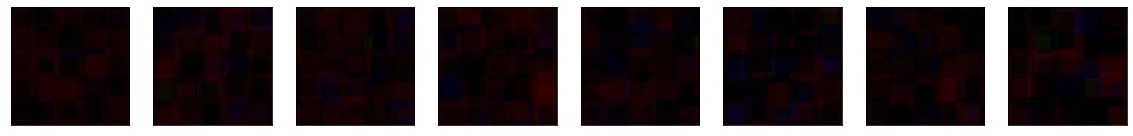

[Step 500] D Loss: 0.0000; G Loss: 0.0000


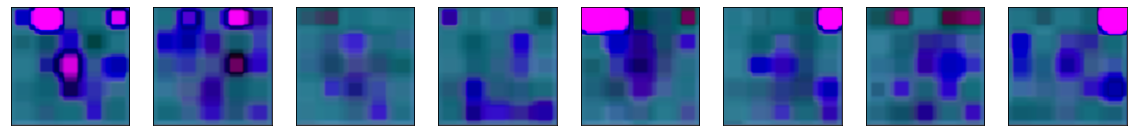

[Step 1000] D Loss: 7.5264; G Loss: 67.4111


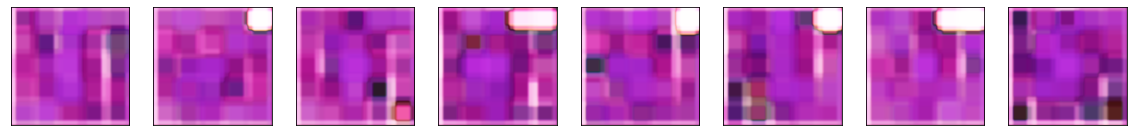

[Step 1500] D Loss: 0.9381; G Loss: 39.6375


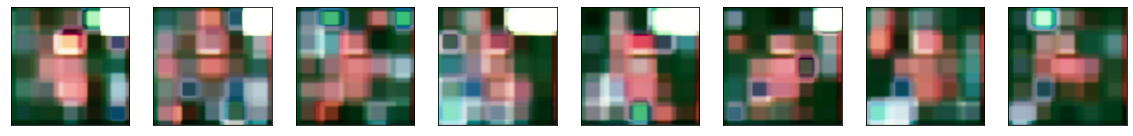

[Step 2000] D Loss: 0.0001; G Loss: 40.0568


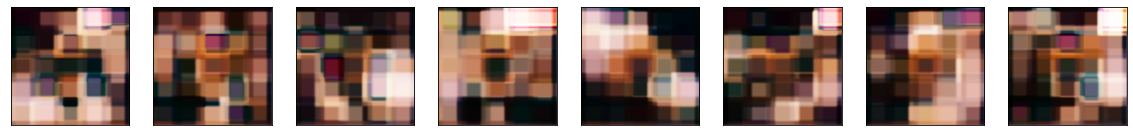

[Step 2500] D Loss: 0.8713; G Loss: 28.6750


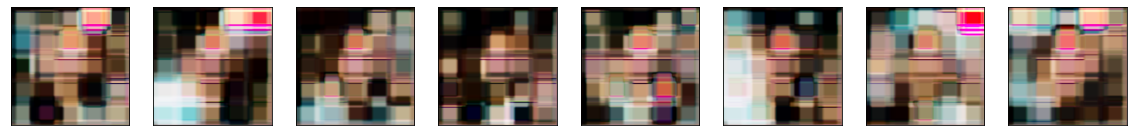

[Step 3000] D Loss: 0.0000; G Loss: 44.2369


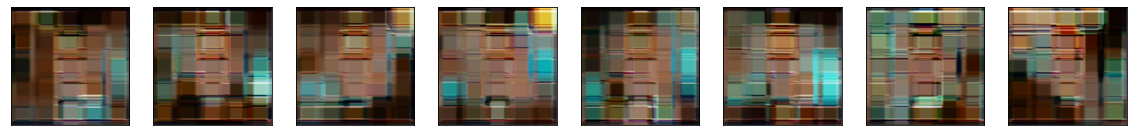

[Step 3500] D Loss: 0.0000; G Loss: 54.6700


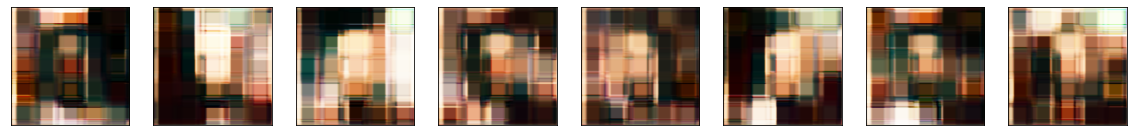

[Step 4000] D Loss: 0.0050; G Loss: 81.3234


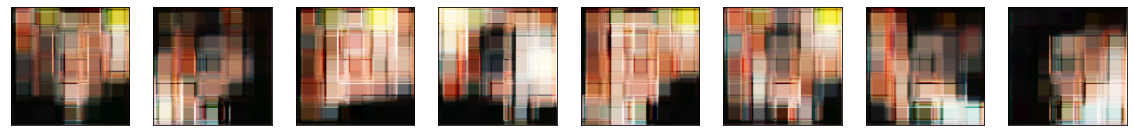

[Step 4500] D Loss: 0.0000; G Loss: 37.5783


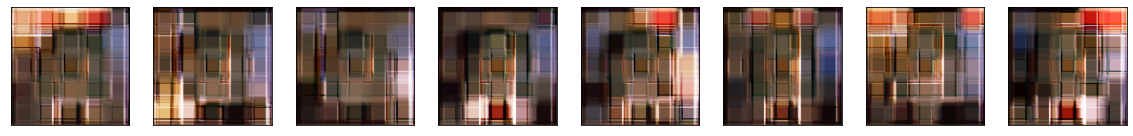

[Step 5000] D Loss: 0.3671; G Loss: 78.9969


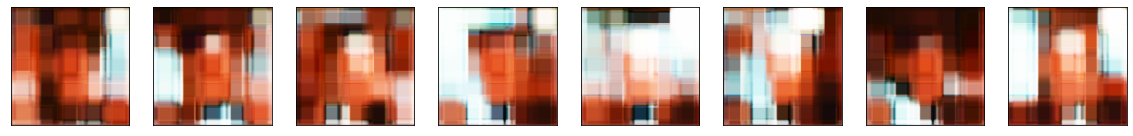

[Step 5500] D Loss: 0.0000; G Loss: 103.9900


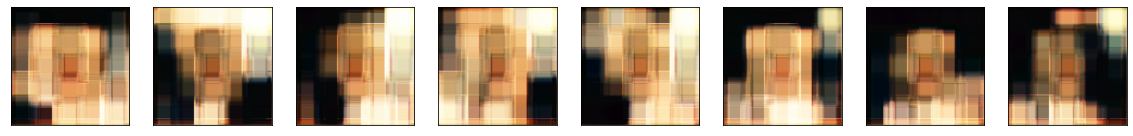

[Step 6000] D Loss: 0.0000; G Loss: 81.9509


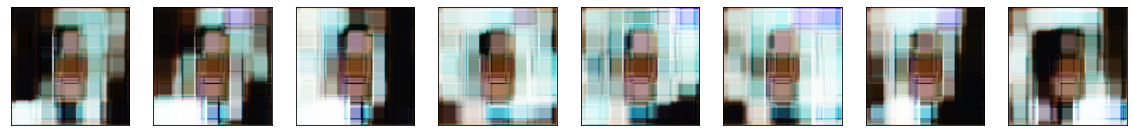

[Step 6500] D Loss: 1.3744; G Loss: 39.8233


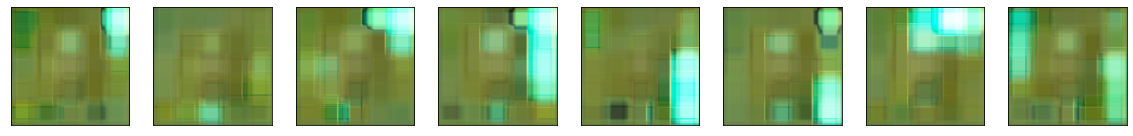

[Step 7000] D Loss: 0.9577; G Loss: 94.2519


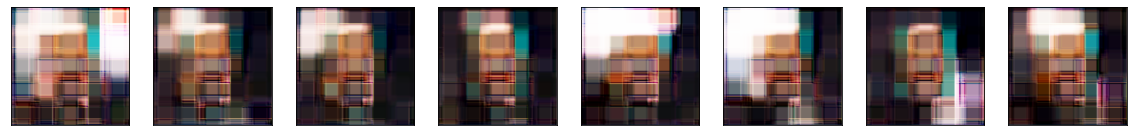

[Step 7500] D Loss: 0.0000; G Loss: 66.4208


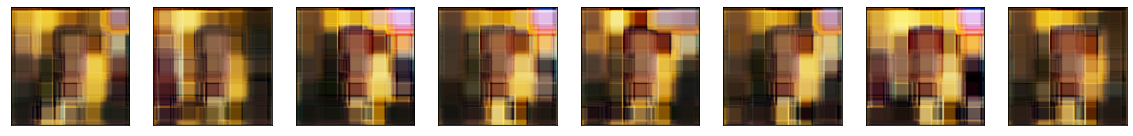

[Step 8000] D Loss: 0.0000; G Loss: 59.6211


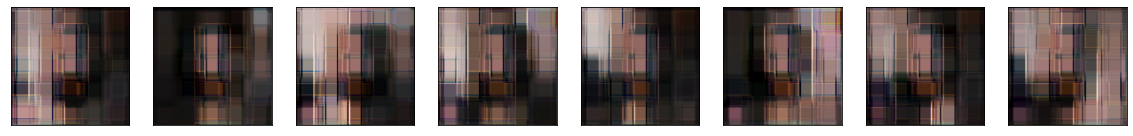

CPU times: user 43min 38s, sys: 15min 58s, total: 59min 36s
Wall time: 3h 55min 11s


In [17]:
%%time
for step, true_images in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 500 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_pics(syntetic_images)


## Тестирование свёрточного генератора

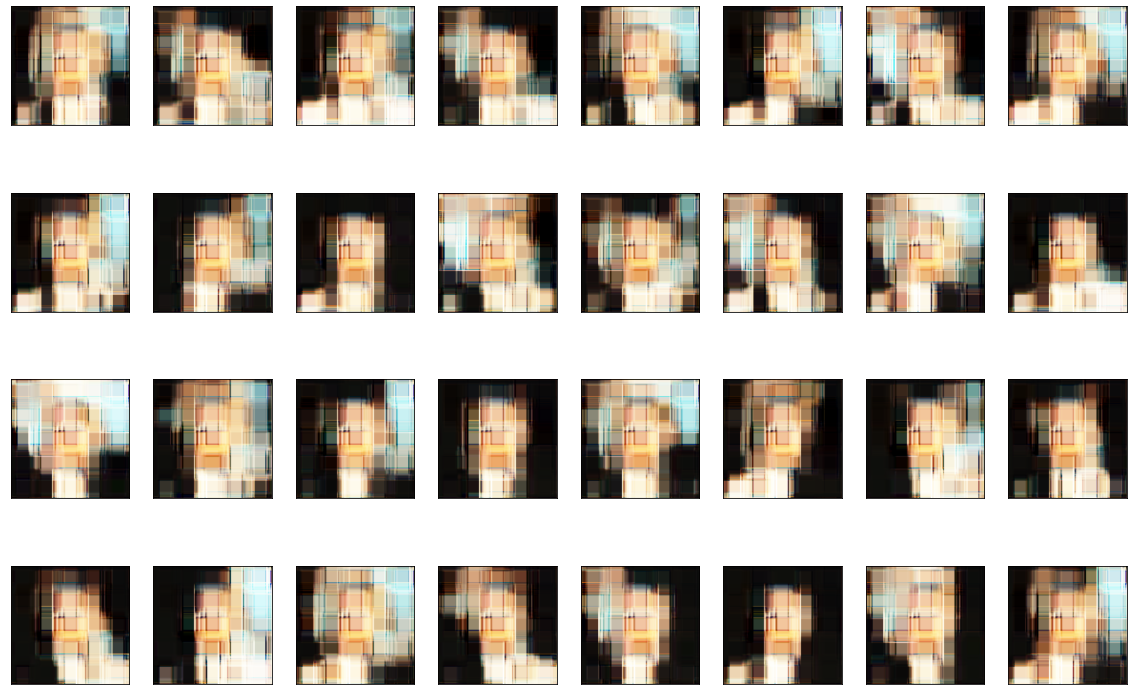

In [18]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_pics(syntetic_images)

## Интерполяция в латентном пространстве

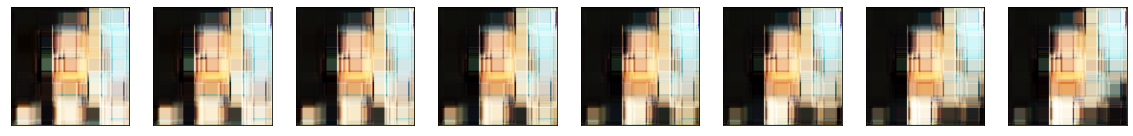

In [19]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_pics(syntetic_images)